<a href="https://colab.research.google.com/github/tianhaoz95/morphling/blob/experiment%2Fstyle-gan/notebooks/style_gan_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Experiment

## Install dependencies

In [0]:
!pip install -q imageio

## Import packages

In [0]:
import glob
import os
import PIL
import time
import imageio
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from IPython import display

## Load and prepare dataset

In [0]:
(raw_train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [7]:
print(raw_train_images.shape)

(60000, 28, 28)


In [0]:
dataset_size = raw_train_images.shape[0]
batch_size = 256
unnormalized_train_images = raw_train_images.reshape(dataset_size, 28, 28, 1)

In [0]:
ordered_train_images = (unnormalized_train_images - (255.0 / 2)) / (255.0 / 2)

In [0]:
train_images = tf.data.Dataset.from_tensor_slices(
    ordered_train_images).shuffle(dataset_size).batch(batch_size)

## Construct generator model

In [0]:
def build_generator_model():
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Reshape((7, 7, 256)))
  model.add(keras.layers.Conv2DTranspose(
      128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Conv2DTranspose(
      64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Conv2DTranspose(
      1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  return model

## Test drive the generator model

In [0]:
generator = build_generator_model()

In [0]:
random_noise = tf.random.normal((1, 100))

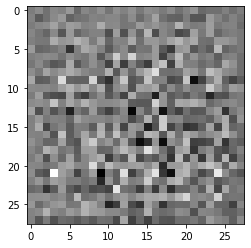

In [30]:
generated_image = generator(random_noise, training=False)
plt.figure()
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

## Build the discriminator

In [0]:
def build_discriminator_model():
  model = keras.models.Sequential()
  model.add(keras.layers.Conv2D(
      64, (5,5), strides=(2,2), padding='same', input_shape=(28, 28, 1)))
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Conv2D(128, (5, 5), strides=(2,2), padding='same'))
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(1))
  return model

### Test drive the discriminator

In [0]:
discriminator = build_discriminator_model()

In [35]:
test_drive_classification = discriminator(generated_image)
print(test_drive_classification)

tf.Tensor([[-0.0032416]], shape=(1, 1), dtype=float32)


## Build the losses

In [0]:
def build_discriminator_loss(real_output, fake_output):
  real_loss = keras.losses.BinaryCrossentropy(
      from_logits=True)(tf.ones_like(real_output), real_output)
  fake_loss = keras.losses.BinaryCrossentropy(
      from_logits=True)(tf.zeros_like(fake_output), fake_output)
  final_loss = real_loss + fake_loss
  return final_loss

In [0]:
def build_generator_loss(fake_output):
  loss = keras.losses.BinaryCrossentropy(from_logits=True)(
      tf.ones_like(fake_output), fake_output)

# Build the optimizers

In [0]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0001)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0001)

## Train

### Configuration